In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
import pickle

## Carga de datos train

In [3]:
df = pd.read_csv("../data/train/train.csv")
df.head()

,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Diagnosis
0,4.862270,2.471408,0,0,9.788456,0
1,28.316033,5.021810,0,0,2.873132,0
2,27.204428,3.819500,1,0,2.150132,0
3,6.177355,0.036686,0,0,2.570051,1
4,6.847389,9.246352,1,0,1.814942,1


In [4]:
X_train = df.drop(["Diagnosis"], axis=1)
y_train = df["Diagnosis"]

## Entrenamiento de modelos

### Prueba con Ada Boost Classifier y GridSearch

In [10]:
ada = AdaBoostClassifier(random_state=11)
parametros = {"n_estimators": [100, 200, 400, 600, 800], "learning_rate": [0.3, 0.5, 0.6, 0.8]} # parámetros para el GS

gs_ada = GridSearchCV(estimator=ada, param_grid=parametros, scoring="recall", cv=3, verbose=3, n_jobs=-1) # pasamos parámetros
gs_ada.fit(X_train, y_train) # Entrenamos con la parte train los parámetros establecidos, scoring en recall

print("Mejor estimator:", gs_ada.best_estimator_) # Mejor combinación de parámetros y modelo
print("Mejor parametro:", gs_ada.best_params_) # Mejores parámetros
print("Mejor recall:", gs_ada.best_score_) # Mejor resultado de recall

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejor estimator: AdaBoostClassifier(learning_rate=0.3, n_estimators=400, random_state=11)
Mejor parametro: {'learning_rate': 0.3, 'n_estimators': 400}
Mejor recall: 0.9026402640264027


## Carga de datos test

In [6]:
df_test = pd.read_csv("../data/test/test.csv")

In [7]:
X_test = df_test.drop(["Diagnosis"], axis=1)
y_test = df_test["Diagnosis"]

In [ ]:
pred_ada = gs_ada.best_estimator_.predict(X_test) # predecimos con la parte de X_test
scores = gs_ada.best_estimator_.predict_proba(X_test)[:,1] # guardamos en scores la predict proba para el AUC

print("Recall:", recall_score(y_test, pred_ada)) # visualizar el recall
print("Accuracy:", accuracy_score(y_test, pred_ada)) # visualizar el accuracy
print("AUC:", roc_auc_score(y_test, scores)) # visualizar el roc_auc
print("CM:", confusion_matrix(y_test, pred_ada)) # visualizar la matriz de confusión
print("Report:", classification_report(y_test, pred_ada)) # visualizar reporte completo

Recall: 0.922077922077922
Accuracy: 0.9441860465116279
AUC: 0.9630623000188218
CM: [[264  12]
 [ 12 142]]
Report:               precision    recall  f1-score   support

           0       0.96      0.96      0.96       276
           1       0.92      0.92      0.92       154

    accuracy                           0.94       430
   macro avg       0.94      0.94      0.94       430
weighted avg       0.94      0.94      0.94       430



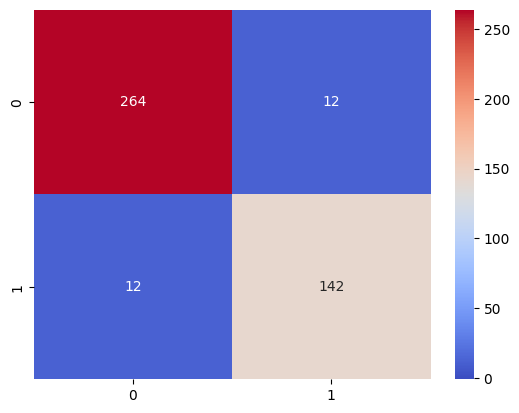

In [9]:
# Mapa de calor de la matriz de confusión para mejor visualización de la misma

sns.heatmap(confusion_matrix(y_test, pred_ada), annot=True, vmin=-1, fmt="d", cmap="coolwarm");

Visualización de un Dataframe con la importancia que el modelo le da a las variables

In [ ]:
df_importances_ada = pd.DataFrame({"Columna": gs_ada.best_estimator_.feature_names_in_, "Importancia": gs_ada.best_estimator_.feature_importances_})
df_importances_ada.sort_values("Importancia", ascending=False)

,Columna,Importancia
0,MMSE,0.361833
1,FunctionalAssessment,0.260846
4,ADL,0.158369
2,MemoryComplaints,0.111677
3,BehavioralProblems,0.107275


Guardado de modelo con pickle

In [12]:
pickle.dump(gs_ada.best_estimator_, open("../models/04_modelo_AdaBoost.pkl", "wb"))